In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as sps
from scipy.integrate import quad
from scipy.special import gamma
from scipy.stats import chi2
from scipy.stats import laplace
from numpy.random import normal as norm

In [4]:
def ar_p(n, theta, sigma):
    x = np.random.normal(0,sigma,len(theta))
    #y = x.copy()
    for i in range(n):
        x = np.append(x,(np.sum(theta*x[-1:-(len(theta)+1):-1])+np.random.normal(0,sigma,1)))
    #data = pd.DataFrame(x,columns=['ar_p'])
    return x

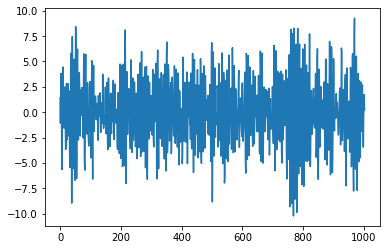

In [5]:
n=1000
#theta=np.array([0.6,0.7,-0.4,-0.45,0.5,-0.4])
theta=np.array([0.6,-0.7,-0.2])
sigma=1.5
ar=ar_p(n,theta,sigma)
plt.plot(ar)

In [6]:
def LSE(x,theta,n1,p):
    #p=len(theta)
    num=0
    den=0
    for i in range(p+1,n1):
        var = np.reshape(x[i-1:i-p-1:-1],(p,1))
        num += var * x[i]
        den += var @ var.transpose()
    den = np.linalg.inv(den)
    return ((den @ num).reshape(1,p)[0])

In [7]:
p=len(theta)
LSE(ar,theta,len(ar),p)

array([ 0.60256705, -0.6970117 , -0.19915672])

In [8]:
scale = 2 ** (-0.5)
x=np.random.laplace(0,scale,100000)

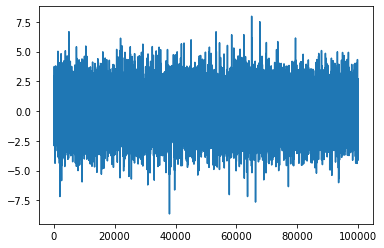

In [9]:
plt.plot(x)

In [10]:
[x.mean(), x.var()]

[0.0018756152386680822, 1.0071325339450397]

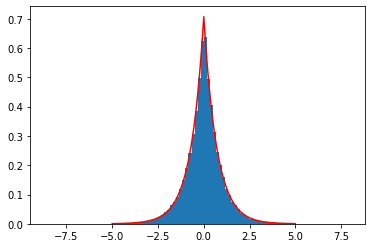

In [11]:
z=np.arange(-5,5,0.01)
plt.hist(x,100,density=True)
plt.plot(z, laplace.pdf(z,0,scale),color='red')

In [12]:
def inf_square(N,n, func):
    y = np.zeros(N)
    for i in range(len(y)):
        z = func(0,1,n) ** 2
        y[i] = 1 / np.sum(z)
    return y

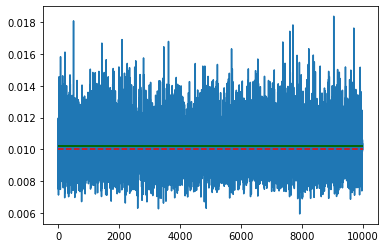

In [13]:
N = 10000
n=100
func = norm
x = inf_square(N, n, func)
plt.plot(x)
plt.hlines(1 / n, 0, N, colors='red', linestyles='dashed', zorder=3)
plt.hlines(1 / (n - 2), 0, N, colors='black', zorder=3)
plt.hlines(x.mean(), 0, N, colors='green', zorder=3)

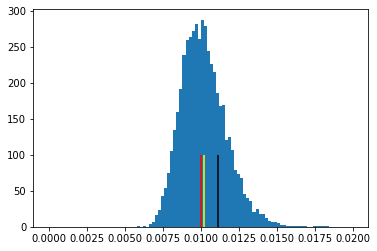

In [14]:
range_min = 0
range_max= 0.02
z=np.arange(0, range_max,0.01)
plt.hist(x,100,(range_min, range_max), density = True)
plt.vlines((1/n, (n-10)**(-1), x.mean()), 0, 100, zorder = 3, colors = ('red', 'black', 'yellow'))
#plt.plot(z, chi2.pdf(z, df = ), zorder = 3)

In [15]:
1/(n-2)

0.01020408163265306

In [16]:
x.mean()

0.010206400085909997

In [17]:
def semi_int(f_1, a, b, delta):
    left = a
    right = b
    f_a = f_1(left)
    f_b = f_1(right)
    c = (left + right) / 2
    f_c = f_1(c)
    if (abs(left - right) > delta):
        if (f_1(left) * f_c < 0):
            return semi_int(f_1, left, c, delta)
        else:
             return semi_int(f_1, c, right, delta)
    else:
        return((right + left) / 2)

In [33]:
def est_var(n, theta, sigma, n1, n2, h, delta):
    if n1>=n2:
        print(f'{n1} >= {n2}')
        return 0
    p =len(theta)
    x = np.random.normal(0,sigma,p)
    #y = x.copy()
    for i in range(n1):
        x = np.append(x,(np.sum(theta*x[-1:-(len(theta)+1):-1])+np.random.normal(0,sigma,1)))
    #Этап оценивания дисперсии
    theta_est = LSE(x,theta,n1,p)
    Sn1n2 = 0
    for i in range(n1,n2):
        x = np.append(x,(np.sum(theta*x[-1:-(len(theta)+1):-1])+np.random.normal(0,sigma,1)))
        Sn1n2 += (x[-1] - np.sum(theta*x[-2:-(p+2):-1])) ** 2
    Gamma = 1 / (n2 - n1 - 2) * Sn1n2 
    A = np.eye(1)
    #нужно ли?
    for i in range(1):
        x = np.append(x,(np.sum(theta*x[-1:-(len(theta)+1):-1])+np.random.normal(0,sigma,1)))
    A = np.zeros((p,p))
    lin_ind = [x[-2:-(p+2):-1]]
    #Рассчет коэффициентов nu_k на первом шаге
    #            p>1   !!!!!!
    while abs(np.linalg.det(A)) < 10 ** (-5):
        x = np.append(x,(np.sum(theta*x[-1:-(len(theta)+1):-1])+np.random.normal(0,sigma,1)))
        lin_ind.append(x[-2:-(p+2):-1])
        k = 0
        for i in range(len(lin_ind)-1):
            two_vec = np.array([lin_ind[i],lin_ind[-1]])
            if np.linalg.matrix_rank(two_vec) == 2:
                k +=1
        if k == (len(lin_ind)-1):
            nu = (Gamma * np.sum(x[-2:-(p+2):-1] ** 2)) ** (-1/2)
        else:
            nu = 0
        print(nu)
        A += nu * x[-2:-(p+2):-1].reshape(p,1) @ x[-2:-(p+2):-1].reshape(1,p)
        print('det =',np.linalg.det(A))
    #Рассчет коэффициентов на втором шаге
    min_lam = 0
    sum_nu2X2 = 0
    k=0
    print(' ')
    while min_lam < h:
        k+=1
        x = np.append(x,(np.sum(theta*x[-1:-(p+1):-1])+np.random.normal(0,sigma,1)))
        x_p = x[-2:-(p+2):-1]
        eq = lambda z: float(np.min(np.linalg.eigvals(A + z * x_p.reshape(p,1) @ x_p.reshape(1,p))) / Gamma - float(sum_nu2X2 + z**2 * x_p.reshape(1,p) @ x_p.reshape(p,1)))
        #print(x_p.reshape(1,p) @ x_p.reshape(p,1))
        nu = float(semi_int(eq, 0, 1, delta))
        A += nu * x_p.reshape(p,1) @ x_p.reshape(1,p) 
        sum_nu2X2 += nu**2 * x_p.reshape(1,p) @ x_p.reshape(p,1)
        min_lam = float(np.min(np.linalg.eigvals(A)))
        print(f'eig={np.linalg.eigvals(A)},\tmin_lam={min_lam},\tnu={round(nu,4)},\tsum_nu2X2={round(float(sum_nu2X2),4)},\tmin_lam/Gamma={round(min_lam/Gamma,4)}')
        
    #уменьшение последнего коэффициента nu_tau
    
    return()

In [34]:
n = 300
theta = np.array([0.6,-0.7,-0.2])
#theta=np.array([0.6,0.7,-0.4,-0.45,0.5,-0.4])
sigma = 1.5
n1 = 10
n2 = 20
h = 5
delta = 0.00001
est_var(n, theta, sigma, n1, n2, h, delta)
if k==10:
            s=np.arange(0,1,0.01)
            s1=[]
            for i in s:
                s1.append(float(eq(i)))
            plt.plot(s,s1)

0.3219825262527052
det = -1.2192212695423281e-34
0.2562447525264661
det = -1.2248012857195021e-17
0.19729056418475702
det = 1.112401657307212
 
eig=[0.78061029 1.79965965 2.04084766],	min_lam=0.7806102948279565,	nu=0.1784,	sum_nu2X2=0.2193,	min_lam/Gamma=0.2193
eig=[0.80319371 1.83458983 2.16546123],	min_lam=0.8031937139420076,	nu=0.0349,	sum_nu2X2=0.2256,	min_lam/Gamma=0.2256
eig=[6.41502851 2.16229362 0.80357604],	min_lam=0.8035760385990471,	nu=1.0,	sum_nu2X2=4.8032,	min_lam/Gamma=0.2257
eig=[0.8162711  4.71177004 8.50592545],	min_lam=0.8162710978700538,	nu=1.0,	sum_nu2X2=9.4563,	min_lam/Gamma=0.2293
eig=[10.81340922  5.85177092  3.40073509],	min_lam=3.4007350876772047,	nu=1.0,	sum_nu2X2=15.4882,	min_lam/Gamma=0.9552
eig=[23.9161388   6.94158726  4.6648405 ],	min_lam=4.664840500612358,	nu=1.0,	sum_nu2X2=30.9448,	min_lam/Gamma=1.3103
eig=[28.50333298 17.67422756  5.02165743],	min_lam=5.021657428171917,	nu=1.0,	sum_nu2X2=46.6214,	min_lam/Gamma=1.4105


()

In [21]:
p = 5
k = 10
Z = np.zeros((p,p))
z = np.random.normal(0,1,p)
Z = z.reshape(5,1)@z.reshape(1,5)
for i in range(k):
    z = np.random.normal(0,1,p)
    Z += z.reshape(5,1)@z.reshape(1,5) 
    
np.linalg.det(Z)

9585.415275669899

In [30]:
p=3
z=np.random.normal(10,2,p)
Z=z.reshape(p,1)@z.reshape(1,p)
np.linalg.eigvals(Z)

array([ 2.44627869e+02, -2.69046976e-14,  5.61688595e-15])

In [31]:
z=[]
for i in range(10):
    z.append(np.random.normal(0,1,4))
np.array(z)
z[-2:]

[array([-0.87415831,  0.37282984,  1.60669863, -0.1505061 ]),
 array([-1.22418927, -1.33643059, -0.92111892, -0.86789181])]

In [32]:
z

[array([-0.31976203, -0.24184565,  0.05941073, -1.34291843]),
 array([-0.03401895, -0.36510899,  0.50875601, -0.55949857]),
 array([-0.98428684, -0.26639606, -2.26630593,  0.03694584]),
 array([-0.6505463 ,  1.26486338, -2.35410391, -0.16389643]),
 array([ 1.19712576, -2.64429239,  0.56963665,  0.71861801]),
 array([-0.09910766,  1.44408525,  0.10511373, -0.60531419]),
 array([-0.62599499,  1.26350497,  0.07553409, -0.15562019]),
 array([-0.3334125 , -0.11373376, -1.03707092,  1.46522721]),
 array([-0.87415831,  0.37282984,  1.60669863, -0.1505061 ]),
 array([-1.22418927, -1.33643059, -0.92111892, -0.86789181])]

In [33]:
np.linalg.matrix_rank(np.array(z))

4

In [211]:
def f_1(x):
    return -x**4 + 2*x + 6

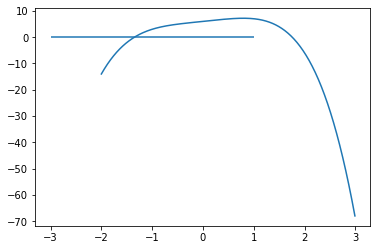

In [212]:
z=np.arange(-2,3,0.01)
plt.plot(z,f_1(z))
plt.hlines(0,-3,1)

In [213]:
z = semi_int(f_1, -2, 3, 0.0000001)

In [214]:
z

-1.348180778324604

In [65]:
z

-1.4561309814453125

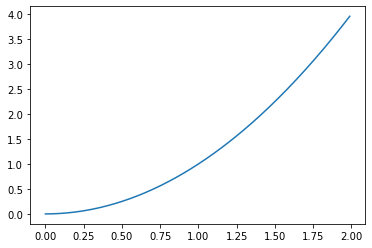

In [127]:
z=np.arange(0,2,0.01)
eq = lambda z: z**2
Z=np.zeros(len(z))
for i in range(len(z)):
    Z[i]=eq(z[i])
plt.plot(z,Z)